### Classification based on point cloud features

In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
#%matplotlib inline
%pylab inline
import os
import sys
from time import time
from glob import glob
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration

Populating the interactive namespace from numpy and matplotlib


In [16]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1

In [3]:
def get_scores(X_train, X_valid, y_train, param, num_round):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_valid)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)
    score = bst.predict(dval, output_margin=True, ntree_limit=bst.best_ntree_limit)
    score = np.around(score, 3)
    
    return score

In [73]:
from sklearn import metrics
def buildROC(target_test,test_preds, num_round,structure):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    #plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label=str(num_round))#, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    loc = np.random.choice(range(len(fpr)),1)[0]
    plt.text(fpr[loc],tpr[loc],structure)
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return roc_auc

In [5]:
paired_structures = ['5N', '6N', '7nn','7N', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

In [342]:
auc_s=[0.95,0.95,0.98,0.95,0.97,0.94,0.89,0.96,0.96,0.92,0.94,0.92,0.895,0.97,0.97,0.95,0.86,0.915,0.93,0.97,0.95,0.92,\
      0.95,0.98,0.965,0.86,0.82,0.88]

In [80]:
len(auc_s)

28

In [338]:
stack = 'MD594'
feature_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V5/'+stack+'/'
cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V5/MD589/'


In [239]:
fn = "/Users/kuiqian/Desktop/Features/CDFtest/Thresholds_V0/"
!mkdir $fn

mkdir: /Users/kuiqian/Desktop/Features/CDFtest/Thresholds_V0/: File exists


In [369]:
!mkdir figures
fn = 'figures/'

mkdir: figures: File exists


5N 480 479 0.7799791449426486
6N 269 216 0.8309278350515464
7nn 999 1000 0.9029514757378689
7N 829 826 0.8211480362537764
Amb 120 120 0.8916666666666667
LC 239 240 0.826722338204593
LRt 720 720 0.7826388888888889
Pn 940 921 0.7759269210102095
Tz 439 437 0.867579908675799
VLL 650 650 0.7661538461538462
RMC 500 500 0.86
SNC 940 883 0.7520570488206253
SNR 999 1000 0.7113556778389195
3N 230 230 0.8478260869565217
4N 140 113 0.8774703557312253
Sp5I 707 709 0.7994350282485876
Sp5O 680 680 0.6852941176470588
Sp5C 1000 1000 0.737
PBG 250 233 0.8240165631469979
10N 330 271 0.848585690515807
VCA 659 638 0.8635312259059368
VCP 449 416 0.7895953757225433
DC 850 811 0.8055388320288982
AP 190 190 0.8789473684210526
12N 389 390 0.8254172015404364
RtTg 800 800 0.67125
SC 999 1000 0.6588294147073537
IC 999 1000 0.7433716858429215


Text(0.5, 1.0, 'MD594')

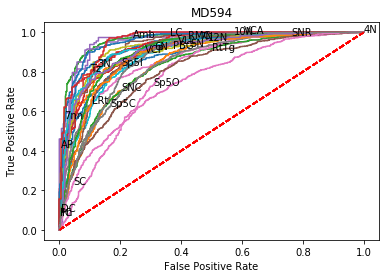

In [339]:
acc_all=[]
num_round=np.array([100])
auc_all = np.zeros((len(num_round), len(all_structures)))
#plt.figure(figsize=[15,50])
plt.figure()
for structure in all_structures:
    seq = np.where(np.array(all_structures)==structure)[0]
    #plt.subplot(10,3,seq+1)
    #plt.figure()
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    fp =[]
    fp.append(feature_dir+structure+'/'+stack+'_'+structure+'_positive.pkl') 
    fp.append(feature_dir+structure+'/'+stack+'_'+structure+'_negative.pkl')
    X_valid = []
    y_valid = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_valid.extend(np.array(clouds))
        y_valid.extend([1-state]*len(clouds))
    X_valid = np.array(X_valid)
    y_valid = np.array(y_valid)
    
    for i in range(len(num_round)):
        y_pred_valid = get_scores(X_train, X_valid, y_train, param, num_round[i])
        pred = y_pred_valid>0
        acc = sum(pred ==y_valid)/len(y_valid)
        auc = buildROC(y_valid, y_pred_valid, num_round[i],structure)
        auc_all[i,seq] = auc
    #plt.title(structure+' AUC = %0.2f'%auc)
    acc_all.append(acc)
    print(structure, len(y_valid)-sum(y_valid), sum(y_valid), acc)
    #plt.savefig(fn+stack+'_'+structure+'_ROC.jpg')
plt.title(stack)
# plt.savefig(fn+stack+'_ROC.jpg')

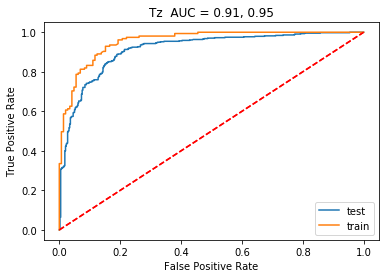

In [67]:
plt.figure()
num_round=np.array([100])
fp =[]
structure = 'Tz'
fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
X_train = []
y_train = []
for state in range(2):
    clouds = pickle.load(open(fp[state],'rb'))
    X_train.extend(np.array(clouds))
    y_train.extend([1-state]*len(clouds))
X_train = np.array(X_train)
y_train = np.array(y_train)

fp =[]
fp.append(feature_dir+structure+'/'+stack+'_'+structure+'_positive.pkl') 
fp.append(feature_dir+structure+'/'+stack+'_'+structure+'_negative.pkl')
X_valid = []
y_valid = []
for state in range(2):
    clouds = pickle.load(open(fp[state],'rb'))
    X_valid.extend(np.array(clouds))
    y_valid.extend([1-state]*len(clouds))
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

for i in range(len(num_round)):
    y_pred_valid = get_scores(X_train, X_valid, y_train, param, num_round[i])
    pred = y_pred_valid>0
    acc = sum(pred ==y_valid)/len(y_valid)
    auc = buildROC(y_valid, y_pred_valid, num_round[i],'test',structure)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.30, random_state=6)
for i in range(len(num_round)):
    y_pred_valid = get_scores(X_train, X_valid, y_train, param, num_round[i])
    pred = y_pred_valid>0
    acc = sum(pred ==y_valid)/len(y_valid)
    auc2 = buildROC(y_valid, y_pred_valid, num_round[i],'train',structure)
legend()
plt.title(structure+'  AUC = %0.2f, %0.2f'%(auc,auc2))
plt.savefig(fn+'ROC_sample.jpg')

In [68]:
fn

'/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/'

In [39]:
good_features = []
for i in np.where(auc_all>auc_all.mean())[1]:
    good_features.append(all_structures[i])
bad_features = []
for i in np.where(auc_all<=auc_all.mean())[1]:
    bad_features.append(all_structures[i])

In [40]:
len(good_features),len(bad_features)

(17, 11)

In [42]:
fp = os.environ['ROOT_DIR'] + 'CSHL_results/'
os.mkdir(fp)
good_fp = fp + 'good/'
os.mkdir(good_fp)
for struc in good_features:
    os.mkdir(good_fp + struc + '/')
    source = os.environ['ROOT_DIR'] + 'CSHL_hsv_new/MD594/'+struc +'/*'
    destination = good_fp + struc + '/test'
    os.mkdir(destination)
    ! mv -v $source $destination
    source = os.environ['ROOT_DIR'] + 'CSHL_hsv_new/MD589/'+struc +'/*'
    destination = good_fp + struc + '/train'
    os.mkdir(destination)
    ! mv -v $source $destination

bad_fp = fp + 'bad/'
os.mkdir(bad_fp)
for struc in bad_features:
    os.mkdir(bad_fp + struc + '/')
    source = os.environ['ROOT_DIR'] + 'CSHL_hsv_new/MD594/'+struc +'/*'
    destination = bad_fp + struc + '/test'
    os.mkdir(destination)
    ! mv -v $source $destination
    source = os.environ['ROOT_DIR'] + 'CSHL_hsv_new/MD589/'+struc +'/*'
    destination = bad_fp + struc + '/train'
    os.mkdir(destination)
    ! mv -v $source $destination

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7nn/7n_145.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7nn/test/7n_145.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7nn/7n_146.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7nn/test/7n_146.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7nn/7n_147.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7nn/test/7n_147.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7nn/7n_148.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7nn/test/7n_148.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7nn/7n_149.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7nn/test/7n_149.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7nn/7n_150.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7nn/te

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7nn/7n_148.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7nn/train/7n_148.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7nn/7n_150.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7nn/train/7n_150.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7nn/7n_151.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7nn/train/7n_151.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7nn/7n_152.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7nn/train/7n_152.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7nn/7n_153.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7nn/train/7n_153.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7nn/7n_154.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7N/7N_151.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_151.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7N/7N_152.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_152.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7N/7N_153.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_153.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7N/7N_154.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_154.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7N/7N_155.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_155.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/7N/7N_156.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_156.ti

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7N/7N_152.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/train/7N_152.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7N/7N_153.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/train/7N_153.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7N/7N_154.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/train/7N_154.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7N/7N_155.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/train/7N_155.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7N/7N_156.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/train/7N_156.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/7N/7N_157.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/train/7N_

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Amb/Amb_167.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Amb/test/Amb_167.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Amb/Amb_168.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Amb/test/Amb_168.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Amb/Amb_169.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Amb/test/Amb_169.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Amb/Amb_170.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Amb/test/Amb_170.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Amb/Amb_171.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Amb/test/Amb_171.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Amb/Amb_172.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LC/LC_175.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/LC/train/LC_175.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LC/LC_176.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/LC/train/LC_176.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LC/LC_177.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/LC/train/LC_177.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LC/LC_178.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/LC/train/LC_178.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LC/LC_179.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/LC/train/LC_179.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LC/LC_180.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/LC/train/LC_

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Pn/Pn_175.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Pn/train/Pn_175.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Pn/Pn_176.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Pn/train/Pn_176.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Pn/Pn_177.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Pn/train/Pn_177.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Pn/Pn_178.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Pn/train/Pn_178.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Pn/Pn_179.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Pn/train/Pn_179.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Pn/Pn_180.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Pn/train/Pn_

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Tz/Tz_190.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_190.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Tz/Tz_191.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_191.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Tz/Tz_192.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_192.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Tz/Tz_194.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_194.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Tz/Tz_195.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_195.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Tz/Tz_196.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_196.ti

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VLL/VLL_130.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VLL/test/VLL_130.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VLL/VLL_132.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VLL/test/VLL_132.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VLL/VLL_133.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VLL/test/VLL_133.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VLL/VLL_134.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VLL/test/VLL_134.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VLL/VLL_135.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VLL/test/VLL_135.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VLL/VLL_136.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VLL/VLL_131.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VLL/train/VLL_131.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VLL/VLL_132.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VLL/train/VLL_132.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VLL/VLL_133.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VLL/train/VLL_133.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VLL/VLL_134.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VLL/train/VLL_134.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VLL/VLL_135.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VLL/train/VLL_135.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VLL/VLL_136.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_res

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RMC/RMC_184.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/test/RMC_184.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RMC/RMC_185.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/test/RMC_185.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RMC/RMC_186.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/test/RMC_186.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RMC/RMC_188.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/test/RMC_188.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RMC/RMC_189.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/test/RMC_189.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RMC/RMC_190.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RMC/RMC_190.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/train/RMC_190.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RMC/RMC_191.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/train/RMC_191.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RMC/RMC_192.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/train/RMC_192.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RMC/RMC_193.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/train/RMC_193.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RMC/RMC_194.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/train/RMC_194.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RMC/RMC_195.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_res

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/3N/3N_211.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_211.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/3N/3N_212.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_212.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/3N/3N_213.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_213.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/3N/3N_214.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_214.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/3N/3N_215.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_215.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/3N/3N_216.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_216.ti

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/4N/4N_208.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/4N/train/4N_208.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/4N/4N_209.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/4N/train/4N_209.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/4N/4N_210.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/4N/train/4N_210.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/4N/4N_211.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/4N/train/4N_211.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/4N/4N_233.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/4N/train/4N_233.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/4N/4N_234.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/4N/train/4N_

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5I/Sp5I_115.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Sp5I/train/Sp5I_115.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5I/Sp5I_116.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Sp5I/train/Sp5I_116.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5I/Sp5I_117.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Sp5I/train/Sp5I_117.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5I/Sp5I_119.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Sp5I/train/Sp5I_119.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5I/Sp5I_120.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Sp5I/train/Sp5I_120.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5I/Sp5I_121.tif -> /Users/kuiqian/BstemAtlasDataBack

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/PBG/PBG_128.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/PBG/test/PBG_128.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/PBG/PBG_129.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/PBG/test/PBG_129.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/PBG/PBG_130.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/PBG/test/PBG_130.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/PBG/PBG_132.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/PBG/test/PBG_132.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/PBG/PBG_133.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/PBG/test/PBG_133.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/PBG/PBG_134.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/10N/10N_211.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/10N/test/10N_211.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/10N/10N_212.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/10N/test/10N_212.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/10N/10N_213.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/10N/test/10N_213.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/10N/10N_214.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/10N/test/10N_214.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/10N/10N_215.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/10N/test/10N_215.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/10N/10N_216.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCA/VCA_100.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCA/test/VCA_100.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCA/VCA_101.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCA/test/VCA_101.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCA/VCA_102.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCA/test/VCA_102.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCA/VCA_103.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCA/test/VCA_103.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCA/VCA_104.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCA/test/VCA_104.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCA/VCA_105.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VCA/VCA_100.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCA/train/VCA_100.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VCA/VCA_101.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCA/train/VCA_101.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VCA/VCA_102.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCA/train/VCA_102.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VCA/VCA_103.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCA/train/VCA_103.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VCA/VCA_104.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCA/train/VCA_104.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/VCA/VCA_105.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_res

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/DC/DC_105.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/test/DC_105.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/DC/DC_106.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/test/DC_106.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/DC/DC_107.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/test/DC_107.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/DC/DC_108.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/test/DC_108.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/DC/DC_109.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/test/DC_109.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/DC/DC_110.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/test/DC_110.ti

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/DC/DC_104.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/train/DC_104.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/DC/DC_105.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/train/DC_105.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/DC/DC_106.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/train/DC_106.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/DC/DC_107.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/train/DC_107.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/DC/DC_108.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/train/DC_108.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/DC/DC_109.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/DC/train/DC_

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/AP/AP_221.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_221.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/AP/AP_222.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_222.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/AP/AP_223.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_223.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/AP/AP_224.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_224.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/AP/AP_225.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_225.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/AP/AP_226.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_226.ti

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/12N/12N_206.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/12N/train/12N_206.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/12N/12N_207.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/12N/train/12N_207.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/12N/12N_208.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/12N/train/12N_208.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/12N/12N_209.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/12N/train/12N_209.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/12N/12N_210.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/12N/train/12N_210.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/12N/12N_211.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_res

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/5N/5N_150.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/5N/train/5N_150.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/5N/5N_151.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/5N/train/5N_151.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/5N/5N_152.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/5N/train/5N_152.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/5N/5N_153.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/5N/train/5N_153.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/5N/5N_154.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/5N/train/5N_154.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/5N/5N_155.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/5N/train/5N_155.ti

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/6N/6N_205.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/train/6N_205.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/6N/6N_209.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/train/6N_209.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/6N/6N_214.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/train/6N_214.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/6N/6N_245.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/train/6N_245.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/6N/6N_251.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/train/6N_251.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/LRt/LRt_160.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/LRt/test/LRt_160

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LRt/LRt_154.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/LRt/train/LRt_154.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LRt/LRt_155.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/LRt/train/LRt_155.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LRt/LRt_156.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/LRt/train/LRt_156.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LRt/LRt_157.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/LRt/train/LRt_157.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LRt/LRt_158.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/LRt/train/LRt_158.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/LRt/LRt_159.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNC/SNC_141.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test/SNC_141.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNC/SNC_142.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test/SNC_142.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNC/SNC_143.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test/SNC_143.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNC/SNC_144.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test/SNC_144.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNC/SNC_145.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test/SNC_145.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNC/SNC_146.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/S

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNC/SNC_145.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/train/SNC_145.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNC/SNC_146.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/train/SNC_146.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNC/SNC_147.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/train/SNC_147.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNC/SNC_148.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/train/SNC_148.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNC/SNC_149.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/train/SNC_149.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNC/SNC_150.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNR/SNR_125.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/test/SNR_125.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNR/SNR_126.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/test/SNR_126.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNR/SNR_127.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/test/SNR_127.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNR/SNR_128.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/test/SNR_128.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNR/SNR_129.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/test/SNR_129.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/SNR/SNR_130.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/S

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNR/SNR_126.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/train/SNR_126.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNR/SNR_127.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/train/SNR_127.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNR/SNR_128.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/train/SNR_128.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNR/SNR_129.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/train/SNR_129.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNR/SNR_130.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/train/SNR_130.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SNR/SNR_131.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5O/Sp5O_126.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/test/Sp5O_126.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5O/Sp5O_127.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/test/Sp5O_127.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5O/Sp5O_128.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/test/Sp5O_128.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5O/Sp5O_129.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/test/Sp5O_129.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5O/Sp5O_130.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/test/Sp5O_130.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5O/Sp5O_132.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_br

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5O/Sp5O_117.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/train/Sp5O_117.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5O/Sp5O_119.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/train/Sp5O_119.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5O/Sp5O_120.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/train/Sp5O_120.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5O/Sp5O_121.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/train/Sp5O_121.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5O/Sp5O_122.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/train/Sp5O_122.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5O/Sp5O_123.tif -> /Users/kuiqian/BstemAtlasDataBackup/uc

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5C/Sp5C_134.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/test/Sp5C_134.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5C/Sp5C_135.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/test/Sp5C_135.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5C/Sp5C_136.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/test/Sp5C_136.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5C/Sp5C_137.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/test/Sp5C_137.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5C/Sp5C_138.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/test/Sp5C_138.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/Sp5C/Sp5C_139.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_br

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5C/Sp5C_125.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/train/Sp5C_125.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5C/Sp5C_126.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/train/Sp5C_126.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5C/Sp5C_127.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/train/Sp5C_127.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5C/Sp5C_128.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/train/Sp5C_128.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5C/Sp5C_129.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/train/Sp5C_129.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/Sp5C/Sp5C_130.tif -> /Users/kuiqian/BstemAtlasDataBackup/uc

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCP/VCP_105.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/VCP/test/VCP_105.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCP/VCP_106.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/VCP/test/VCP_106.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCP/VCP_107.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/VCP/test/VCP_107.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCP/VCP_108.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/VCP/test/VCP_108.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCP/VCP_109.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/VCP/test/VCP_109.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/VCP/VCP_110.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/V

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RtTg/RtTg_188.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/test/RtTg_188.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RtTg/RtTg_189.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/test/RtTg_189.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RtTg/RtTg_190.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/test/RtTg_190.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RtTg/RtTg_191.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/test/RtTg_191.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RtTg/RtTg_192.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/test/RtTg_192.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/RtTg/RtTg_194.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_br

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RtTg/RtTg_200.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/train/RtTg_200.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RtTg/RtTg_204.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/train/RtTg_204.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RtTg/RtTg_215.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/train/RtTg_215.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RtTg/RtTg_220.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/train/RtTg_220.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RtTg/RtTg_222.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/train/RtTg_222.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/RtTg/RtTg_223.tif -> /Users/kuiqian/BstemAtlasDataBackup/uc

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SC/SC_128.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/train/SC_128.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SC/SC_129.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/train/SC_129.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SC/SC_130.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/train/SC_130.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SC/SC_131.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/train/SC_131.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SC/SC_132.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/train/SC_132.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/SC/SC_133.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/train/SC_133.ti

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/IC/IC_138.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_138.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/IC/IC_139.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_139.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/IC/IC_140.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_140.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/IC/IC_141.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_141.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/IC/IC_142.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_142.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD594/IC/IC_143.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_143.tif
/Use

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/IC/IC_122.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/train/IC_122.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/IC/IC_123.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/train/IC_123.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/IC/IC_124.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/train/IC_124.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/IC/IC_125.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/train/IC_125.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/IC/IC_126.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/train/IC_126.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv_new/MD589/IC/IC_127.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/train/IC_127.ti

5N 440 440 0.803030303030303
6N 50 43 0.8928571428571429
7nn 1000 1000 0.925
7N 890 884 0.8649155722326454
Amb 130 130 0.8589743589743589
LC 240 240 0.8611111111111112
LRt 760 760 0.7982456140350878
Pn 1000 992 0.8946488294314381
Tz 500 500 0.8833333333333333
VLL 690 690 0.8743961352657005
RMC 570 570 0.8625730994152047
SNC 829 785 0.8845360824742268
SNR 1000 1000 0.7866666666666666
3N 240 240 0.9027777777777778
4N 120 45 0.92
Sp5I 729 730 0.8333333333333334
Sp5O 680 662 0.7766749379652605
Sp5C 1000 1000 0.7916666666666666
PBG 260 216 0.8391608391608392
10N 460 405 0.85
VCA 659 647 0.8979591836734694
VCP 490 475 0.8137931034482758
DC 997 1000 0.8583333333333333
AP 149 145 0.9662921348314607
12N 388 390 0.8846153846153846
RtTg 150 150 0.8111111111111111
SC 999 1000 0.7066666666666667
IC 998 1000 0.84


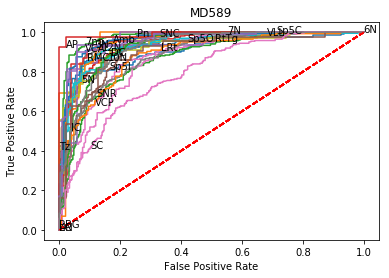

In [241]:
acc_all_train=[]
num_round=np.array([100])
auc_all_train = np.zeros((len(num_round), len(all_structures)))
plt.figure() #figsize=[15,50]
for structure in all_structures:
    seq = np.where(np.array(all_structures)==structure)[0]
    #plt.subplot(10,3,seq+1)
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        features.extend(np.array(clouds))
        labels.extend([1-state]*len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.30, random_state=6)
    for i in range(len(num_round)):
        y_pred_valid = get_scores(X_train, X_valid, y_train, param, num_round[i])
        pred = y_pred_valid>0
        acc = sum(pred ==y_valid)/len(y_valid)
        auc = buildROC(y_valid, y_pred_valid, num_round[i],structure)
        auc_all_train[i,seq] = auc
    #plt.title(structure+' AUC = %0.2f'%auc)
    acc_all_train.append(acc)
    print(structure, len(labels)-sum(labels), sum(labels), acc)
plt.title('MD589')
plt.savefig(fn+'MD589_ROC.jpg')

In [343]:
auc_s=np.array(auc_s)

In [97]:
auc_both=np.concatenate((auc_all,auc_s.reshape(1,-1)),axis=0)
auc_both,auc_both.shape[0]

(array([[0.90901835, 0.87993081, 0.9523975 , 0.89754514, 0.95229167,
         0.87580729, 0.85113873, 0.91032506, 0.92332796, 0.89632308,
         0.91724   , 0.85559264, 0.850872  , 0.93171078, 0.97262958,
         0.87804784, 0.80178093, 0.80918118, 0.89066094, 0.89636587,
         0.93143939, 0.90323985, 0.89016755, 0.95012465, 0.94153517,
         0.80719844, 0.7435705 , 0.8663785 ],
        [0.95      , 0.95      , 0.98      , 0.95      , 0.97      ,
         0.94      , 0.89      , 0.96      , 0.96      , 0.92      ,
         0.94      , 0.92      , 0.895     , 0.97      , 0.97      ,
         0.95      , 0.86      , 0.915     , 0.93      , 0.97      ,
         0.95      , 0.92      , 0.95      , 0.98      , 0.965     ,
         0.86      , 0.82      , 0.88      ]]), 2)

In [319]:
auc_both = []

In [344]:
auc_both.append(auc_s)

In [346]:
auc_both = np.array(auc_both)

In [353]:
auc_all = []
for i in range(6):
    auc_all.append(auc_both[i][0])

In [355]:
auc_all.append(auc_s)

In [356]:
auc_all = np.array(auc_all)
auc_all.shape

(7, 28)

In [358]:
labels = []
for i in range(6):
    labels.append('V'+str(i))
labels.append('Yuncong')
labels

['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'Yuncong']

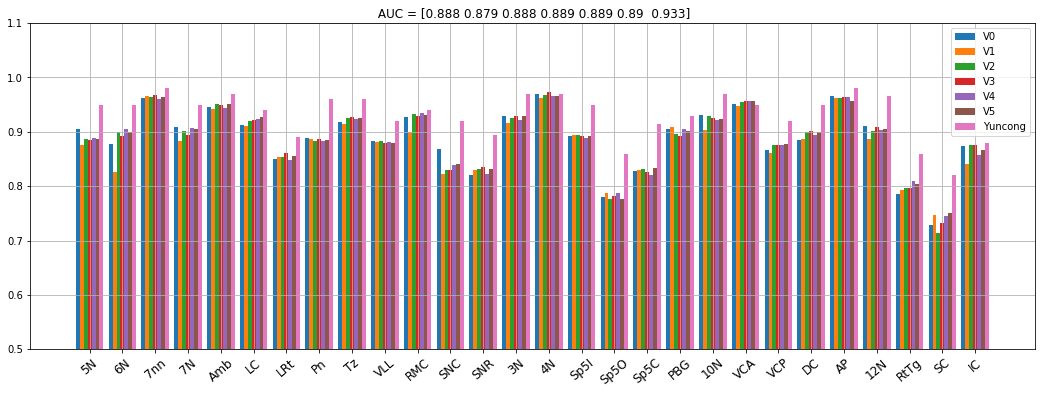

In [370]:
figure(figsize=(18,6))
index = np.arange(auc_all.shape[1])
width = 0.12
labels = []
for i in range(6):
    labels.append('V'+str(i))
labels.append('Yuncong')   
for i in range(auc_all.shape[0]):
    plt.bar(index+i*width, auc_all[i,:], width, label=labels[i])
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width*3, all_structures)
plt.grid(True)
plt.ylim(0.5,1.1)
plt.legend()
plt.title(' AUC = '+str(np.round(np.mean(auc_all,1),3)))
plt.savefig(fn+'Thresholds.jpg')

In [242]:
auc_both=np.concatenate((np.array(auc_all).reshape(1,-1),np.array(auc_all_train).reshape(1,-1)),axis=0)
auc_both,auc_both.shape[0]

(array([[0.90502349, 0.87808929, 0.9622998 , 0.90808232, 0.94583333,
         0.91348501, 0.85054205, 0.88848731, 0.91797199, 0.88294438,
         0.927936  , 0.86766403, 0.82129129, 0.92987713, 0.96975348,
         0.89201876, 0.77976319, 0.828386  , 0.90587124, 0.93163927,
         0.95183759, 0.86732001, 0.88569885, 0.96551247, 0.911433  ,
         0.78575078, 0.72806463, 0.87304709],
        [0.90206334, 0.96923077, 0.97624827, 0.94052749, 0.96710526,
         0.93943498, 0.87204015, 0.9561763 , 0.95766407, 0.9326417 ,
         0.93555175, 0.94897872, 0.86578549, 0.95123839, 0.9375    ,
         0.92155591, 0.85589207, 0.88124137, 0.92662722, 0.93849218,
         0.96291041, 0.87958999, 0.92575503, 0.99132653, 0.95960187,
         0.90153389, 0.7903619 , 0.92189779]]), 2)

In [243]:
acc_both=np.concatenate((np.array(acc_all).reshape(1,-1),np.array(acc_all_train).reshape(1,-1)),axis=0)
acc_both,acc_both.shape[0]

(array([[0.78936392, 0.79587629, 0.91245623, 0.82598187, 0.9125    ,
         0.81837161, 0.77361111, 0.76732939, 0.85502283, 0.76      ,
         0.869     , 0.79319803, 0.68034017, 0.86521739, 0.8972332 ,
         0.78248588, 0.69264706, 0.724     , 0.8115942 , 0.85524126,
         0.86198921, 0.77109827, 0.77664058, 0.90526316, 0.83440308,
         0.6675    , 0.64614615, 0.75575576],
        [0.8030303 , 0.89285714, 0.925     , 0.86491557, 0.85897436,
         0.86111111, 0.79824561, 0.89464883, 0.88333333, 0.87439614,
         0.8625731 , 0.88453608, 0.78666667, 0.90277778, 0.92      ,
         0.83333333, 0.77667494, 0.79166667, 0.83916084, 0.85      ,
         0.89795918, 0.8137931 , 0.85833333, 0.96629213, 0.88461538,
         0.81111111, 0.70666667, 0.84      ]]), 2)

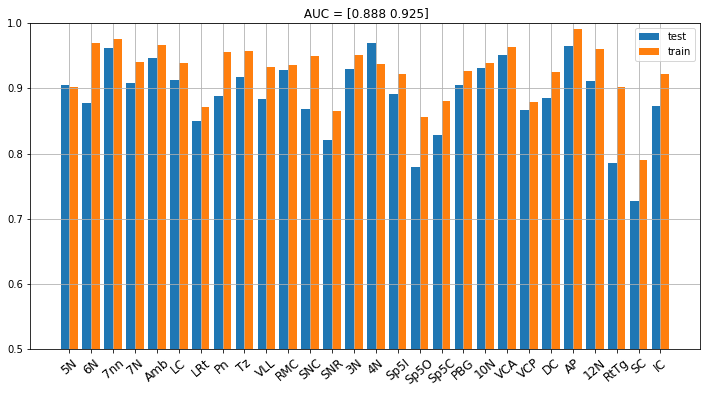

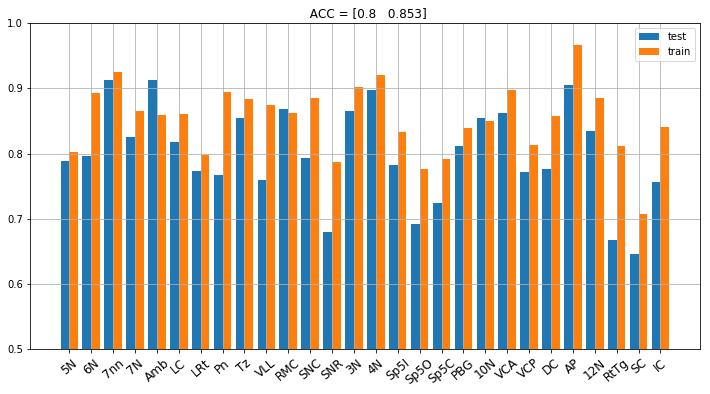

In [244]:
figure(figsize=(12,6))
index = np.arange(auc_both.shape[1])
width = 0.4
labels=['test','train'] #['Present','Yuncong']  
for i in range(auc_both.shape[0]):
    plt.bar(index+i*width, auc_both[i,:], width, label=labels[i])
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, all_structures)
plt.grid(True)
plt.ylim(0.5,1)
plt.legend()
plt.title(' AUC = '+str(np.round(np.mean(auc_both,1),3)))
plt.savefig(fn+'AUC.jpg')

figure(figsize=(12,6))
index = np.arange(acc_both.shape[1])
width = 0.4
labels=['test','train']
for i in range(auc_both.shape[0]):
    plt.bar(index+i*width, acc_both[i,:], width, label=labels[i])
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, all_structures)
plt.grid(True)
plt.ylim(0.5,1)
plt.legend()
plt.title('  ACC = '+str(np.round(np.mean(acc_both,1),3)))
plt.savefig(fn+'ACC.jpg')

In [250]:
auc = [[0.888,0.879,0.888,0.889,0.889,0.89],[0.925,0.918,0.928,0.927,0.927,0.922]]
auc = np.array(auc)
col = []
for i in range(6):
    col.append('V'+str(i))

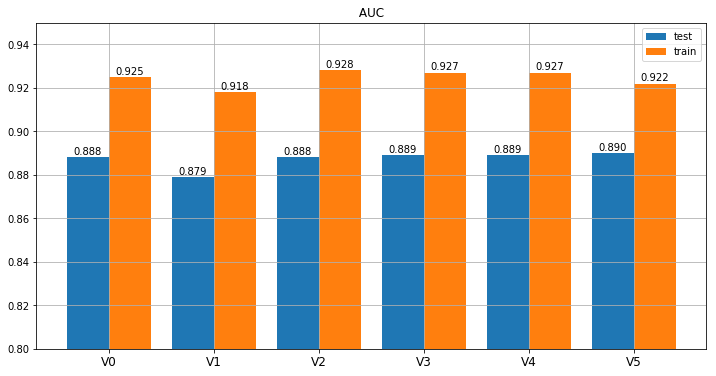

In [262]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0005*height,
                '%.3f' % height,
                ha='center', va='bottom')
fig, ax = plt.subplots(figsize=(12,6))
index = np.arange(auc.shape[1])
width = 0.4
labels=['test','train']  
for i in range(auc.shape[0]):
    rect = ax.bar(index+i*width, auc[i,:], width, label=labels[i])
    autolabel(rect)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, col)
plt.grid(True)
plt.ylim(0.8,0.95)
plt.legend()
plt.title(' AUC ')
plt.savefig(fn+'com.jpg') 

In [39]:
bad_features

['6N', 'LC', 'LRt', 'SNC', 'SNR', 'Sp5I', 'Sp5O', 'Sp5C', 'RtTg', 'SC', 'IC']

In [41]:
bad_features

['5N', '6N', 'LRt', 'SNC', 'SNR', 'Sp5O', 'Sp5C', 'VCP', 'RtTg', 'SC', 'IC']

In [44]:
train_good_but_test_bad = ['6N','SNC','IC']

In [45]:
fp = os.environ['ROOT_DIR'] + 'CSHL_results/'
#os.mkdir(fp)
tfp = fp + 'train_good_but_test_bad/'
os.mkdir(tfp)
for struc in train_good_but_test_bad:
    #os.mkdir(tfp + struc + '/')
    source = fp+'bad/'+struc +'/*'
    destination = tfp + struc + '/'
    os.mkdir(destination)
    ! mv -v $source $destination

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/test -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_bad/6N/test
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/train -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_bad/6N/train
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_bad/SNC/test
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/train -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_bad/SNC/train
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_bad/IC/test
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/train -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_b

In [46]:
fp = os.environ['ROOT_DIR'] + 'CSHL_results/'
for structure in paired_structures:
    if structure in good_features:
        fn = fp+'good/'+ structure +'/'
    elif structure in train_good_but_test_bad:
        fn = fp+'train_good_but_test_bad/'+ structure +'/'
    else:
        fn = fp+'bad/'+ structure +'/'
    if structure == '7nn':
        structure = '7n'
    for state in ['train','test']:
        files = [dir for dir in glob(fn+state+'/*')]
        if os.path.exists(fn+state+'/one_side'):
            continue
        else:
            os.mkdir(fn+state+'/one_side')
            os.mkdir(fn+state+'/the_other')
        sections = []
        for name in files:
            slash=name.rfind('_')
            dot = name.rfind('.')
            sections.append(int(name[slash+1:dot]))
        sections = np.sort(sections)
        mark = np.argmax(sections[1:]-sections[:-1])
        for section in sections[:mark+1]:
            filename = fn + state + '/'+structure +'_'+str(section)+'.tif'
            destination = fn+state+'/one_side/'
            ! mv $filename $destination
        for section in sections[mark+1:]:
            filename = fn + state + '/'+structure +'_'+str(section)+'.tif'
            destination = fn+state+'/the_other/'
            ! mv $filename $destination

In [53]:
structure = '6N'
if structure in good_features:
    fn = fp+'good/'+ structure +'/'
elif structure in train_good_but_test_bad:
    fn = fp+'train_good_but_test_bad/'+ structure +'/'
else:
    fn = fp+'bad/'+ structure +'/'
for state in ['train','test']:
    files = [dir for dir in glob(fn+state+'/*')]
    sections = []
    for name in files:
        slash=name.rfind('_')
        dot = name.rfind('.')
        sections.append(int(name[slash+1:dot]))
    sections = np.sort(sections)
    np.argmax(sections[1:]-sections[:-1])


2
13


Text(0.5, 1.0, '  ACC = [0.783 0.851]')

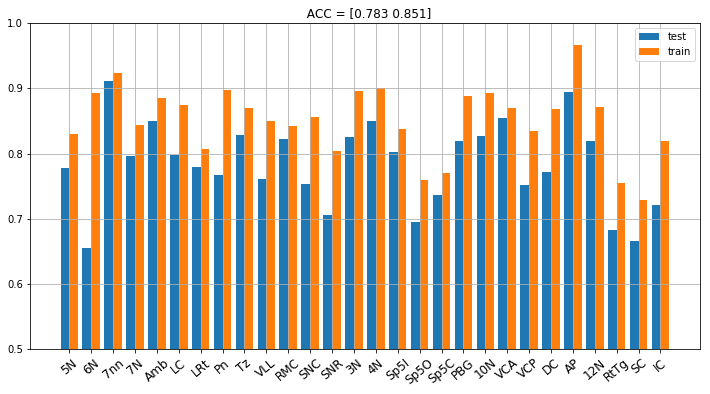

In [19]:
figure(figsize=(12,6))
index = np.arange(acc_both.shape[1])
width = 0.4
labels=['test','train']
for i in range(auc_both.shape[0]):
    plt.bar(index+i*width, acc_both[i,:], width, label=labels[i])
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, all_structures)
plt.grid(True)
plt.ylim(0.5,1)
plt.legend()
plt.title('  ACC = '+str(np.round(np.mean(acc_both,1),3)))
#plt.savefig(fn+stack+'_AUC.jpg')

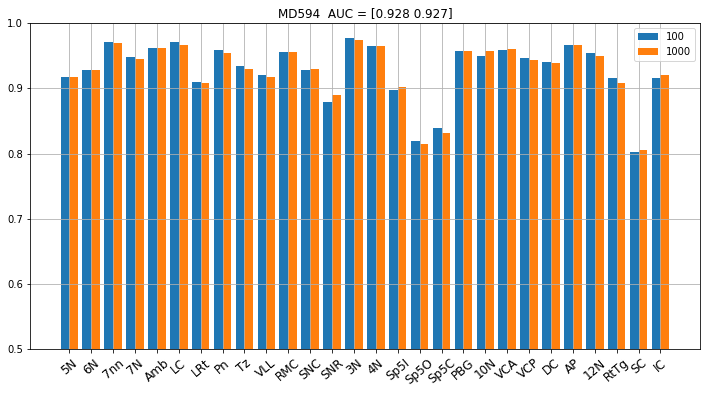

In [17]:
figure(figsize=(12,6))
index = np.arange(auc_all.shape[1])
width = 0.4
for i in range(len(num_round)):
    plt.bar(index+i*width, auc_all[i,:], width, label=str(num_round[i]))
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, all_structures)
plt.grid(True)
plt.ylim(0.5,1)
plt.legend()
plt.title(stack+'  AUC = '+str(np.round(np.mean(auc_all,1),3)))
plt.savefig(fn+'MD589_AUC.jpg')

In [30]:
!aws s3 ls s3://mousebrainatlas-data/CSHL_data_processed/MD585/

                           PRE MD585_custom_transforms/
                           PRE MD585_elastix_output/
                           PRE MD585_masks/
                           PRE MD585_masks_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141/
                           PRE MD585_masks_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped/
                           PRE MD585_prep1_thumbnail/
                           PRE MD585_prep1_thumbnail_mask/
                           PRE MD585_prep2_down8_grayJpeg/
                           PRE MD585_prep2_lossless/
                           PRE MD585_prep2_lossless_gray/
                           PRE MD585_prep2_lossless_jpeg/
                           PRE MD585_prep2_thumbnail/
                           PRE MD585_prep3_lossless/
                           PRE MD585_prep3_lossless_jpeg/
                           PRE MD585_prep3_thumbnail/
                           PRE MD585_prep5_thumbnail/
                           PRE 

In [7]:
origin= ['area', 'height', 'horiz_std', 'mean', 'padded_size',
       'rotation', 'rotation_confidence', 'std', 'vert_std', 'width', 'density']
columns = []
for i in range(10):
    name = 'DMVec'+str(i)
    for j in range(10):
        columns.append(name+'*'+str(np.around(0.1*(j+1),2)))
for i in range(10):
    name = origin[i]
    for j in range(10):
        columns.append(name+'*'+str(np.around(0.1*(j+1),2)))
columns.append(origin[-1])

In [8]:
sets = columns
! mkdir FeatureMap

mkdir: FeatureMap: File exists


LC 479 0.875


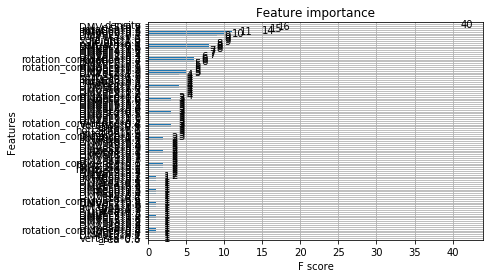

In [13]:
structure = 'LC'
fp =[dir for dir in glob(cell_dir+structure+'/*')]
features = []
labels = []
for state in range(2):
    clouds = pickle.load(open(fp[state],'rb'))
    features.extend(np.array(clouds))
    labels.extend([state]*len(clouds))
features = np.array(features)
labels = np.array(labels)
data = pd.DataFrame(features,columns=sets)
label = pd.DataFrame(labels)
X_train, X_valid, y_train, y_valid = train_test_split(data, label, test_size=0.30, random_state=6)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_valid)
num_round = 100
bst = xgb.train(param, dtrain, num_round, verbose_eval=False)
score = bst.predict(dval, output_margin=True, ntree_limit=bst.best_ntree_limit)
y_pred_valid = np.around(score, 3)
pred = y_pred_valid>0
acc = sum(pred.reshape(-1,1) == np.array(y_valid))/len(y_valid)
print(structure, features.shape[0], acc)
xgb.plot_importance(bst)
# plt.savefig('FeatureMap/'+structure+'.jpg')
# fig = plt.figure(figsize=(18,18))
# iax = fig.add_subplot(111)
# xgb.plot_tree(bst,ax=iax)
# plt.savefig('FeatureMap/'+structure+'_tree.jpg')

In [9]:
def setup_download_from_s3( rel_fp, recursive=True ):
    s3_fp = 's3://mousebrainatlas-data/'+rel_fp
    local_fp = os.environ['ROOT_DIR']+rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return 
    
    if recursive:
        ! aws s3 cp --recursive $s3_fp $local_fp
    else:
        ! aws s3 cp $s3_fp $local_fp

In [313]:
def CDF(x,state):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
#     plot(x,y,label=state)
    return x,y

In [157]:
setup_download_from_s3('CSHL_cells_features/MD589/Properties/7N/')

NameError: name 'setup_download_from_s3' is not defined

In [371]:
cell_dir = os.environ['ROOT_DIR'] + 'CSHL_cells_features/MD589/Properties/'

In [3]:
fp = [dir for dir in glob(cell_dir+'10N/*')]
sample = pickle.load(open(fp[0],'rb'))

In [7]:
sample

,DMVec,area,height,horiz_std,left,mean,padded_size,rotation,rotation_confidence,std,top,vert_std,width
1,"[-3.5152447958216593, -2.4316020148778397, -0....",412,24,4.152117,460,10.763241,51,69.735691,1268.076206,20.917839,449,10.042974,34
2,"[4.67530863811092, -2.4246536527461915, -1.452...",66,15,1.868604,511,3.403200,51,10.968166,926.371727,10.802399,458,3.202521,9
3,"[3.998911116627495, -0.9465917069956651, -1.38...",109,14,2.532682,541,8.241966,51,31.166937,329.498842,17.332238,471,3.316311,15
4,"[3.0411400440305685, -0.13535307086633966, -0....",158,17,2.069978,521,4.198367,51,49.565150,8608.868286,12.370498,479,4.757877,21
5,"[-2.007957337357257, 2.4614147355173106, -0.98...",25,5,1.195420,567,3.595041,15,-49.199080,44.314805,8.034614,478,1.384819,6
6,"[0.4876208951898243, 0.3527127042971828, -0.45...",15,3,0.744536,581,1.049587,15,72.210510,313.772581,3.159274,481,1.450085,7
7,"[-948.6597593791562, 0.09282533612197208, 0.02...",369,26,3.128848,456,9.485198,201,57.911175,5830.029236,24.849796,484,8.592631,30
8,"[-851.5699899794856, -0.7078868175606065, -0.4...",751,39,8.338235,575,8.512356,201,-56.520100,952.147502,20.955519,488,10.584109,46
9,"[3.5226356651475585, -0.011158427050531973, -1...",144,15,2.556931,512,9.844800,51,28.968349,677.567077,20.178244,503,3.593947,14
10,"[-3.3644755350965387, -1.255952782345239, -2.3...",521,24,5.308857,536,13.498416,51,69.078687,4439.118978,26.462562,504,7.309501,33


In [87]:
origin= ['area', 'height', 'horiz_std', 'mean', 'padded_size',
       'rotation', 'rotation_confidence', 'std', 'vert_std', 'width']
columns = []
for i in range(10):
    name = 'DMVec'+str(i)
    columns.append(name)
columns.extend(origin)

In [372]:
%%time
thresholds = {}
for structure in all_structures:
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
    features = []
    labels = []
    tens = []
    for state in range(2):
        cells = pickle.load(open(fp[state],'rb'))
        cells = cells.drop(['left','top'],1)
        cells = np.asarray(cells)
        for k in range(len(cells)):
            cells[k][0] = cells[k][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        features.extend(origin)
        labels.extend([state]*len(origin))
    features = np.array(features)
    labels = np.array(labels)
    for k in range(features.shape[1]):
        print(k)
        x1, y1 = CDF(features[labels==1,k],'positive')
        x2, y2 = CDF(features[labels==0,k],'negative')
        if len(x1)<len(x2):
            x, y = x1, y1
            xc, yc = x2, y2
        else:
            x, y = x2, y2
            xc, yc = x1, y1
        for i in range(len(x)):
            if x[i] in xc:
                index = np.where(xc==x[i])[0][0]
                y[i] = (y[i]+yc[index])/2
            else:
#                 left = np.argmin(np.absolute(xc-x[i]))
#                 right = left - int(np.sign(xc[left]-x[i]))
#                 value = yc[left] + (x[i]-xc[left])/(xc[right]-xc[left])*(yc[right]-yc[left])
                y[i] = (y[i]+yc[np.argmin(np.absolute(xc-x[i]))])/2
        ten = [x[np.argmin(np.absolute(y-0.01*(j+1)))] for j in range(99)]
        tens.append(ten)
    thresholds[structure]=tens
    print(structure)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
5N
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
6N
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
7nn
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
7N
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Amb
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
LC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
LRt
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Pn
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Tz
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
VLL
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
RMC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
SNC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
SNR
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
3N
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
4N
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Sp5I
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Sp5O
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Sp5C
0
1
2
3
4
5
6
7
8
9
10
11
12
13
1

KeyboardInterrupt: 

In [375]:
pickle.dump(thresholds, open(os.environ['ROOT_DIR']+'CSHL_cells_features/thresholds.pkl','wb'))

In [415]:
threshold_ap = pickle.load(open(os.environ['ROOT_DIR']+'CSHL_cells_features/12N.pkl','rb'))

In [402]:
threshold_v5 = pickle.load(open(os.environ['ROOT_DIR']+'CSHL_data_processed/MD589/ThresholdsV5.pkl','rb'))

In [425]:
np.array(threshold_ap['12N'][1]).dtype

dtype('float64')

In [395]:
cells = pickle.load(open(fp[state],'rb'))

In [397]:
cells.dtypes

DMVec                   object
area                     int64
height                   int64
horiz_std              float64
left                     int64
mean                   float64
padded_size              int64
rotation               float64
rotation_confidence    float64
std                    float64
top                      int64
vert_std               float64
width                    int64
dtype: object

In [308]:
fp =[]
structure = 'SC'
fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
features = []
labels = []
tens = []
for state in range(2):
    cells = pickle.load(open(fp[state],'rb'))
    cells = cells.drop(['left','top'],1)
    cells = np.asarray(cells)
    for k in range(len(cells)):
        cells[k][0] = cells[k][0][:10]
    origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
    features.extend(origin)
    labels.extend([state]*len(origin))
features = np.array(features)
labels = np.array(labels)

In [312]:
features.shape, features[labels==1].shape, features[labels==0].shape

((1630974, 20), (973611, 20), (657363, 20))

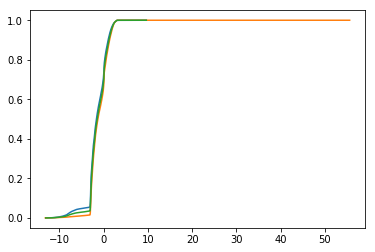

In [306]:
x1, y1 = CDF(features[labels==1,1],'positive')
x2, y2 = CDF(features[labels==0,1],'negative')
if len(x1)<len(x2):
    x, y = x1, y1
    xc, yc = x2, y2
else:
    x, y = x2, y2
    xc, yc = x1, y1
for i in range(len(x)):
    if x[i] in xc:
        index = np.where(xc==x[i])[0][0]
        y[i] = (y[i]+yc[index])/2
    else:
        left = np.argmin(np.absolute(xc-x[i]))
        right = left - int(np.sign(xc[left]-x[i]))
        value = yc[left] + (x[i]-xc[left])/(xc[right]-xc[left])*(yc[right]-yc[left])
        y[i] = (y[i]+value)/2
plot(x,y)

In [307]:
x.shape, y.shape, y1.shape

((32724,), (32724,), (32724,))

In [305]:
int(np.sign(-1.5))

-1

In [298]:
x1[3000] in x2

False

In [141]:
len(thresholds['7nn'][0])

99

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


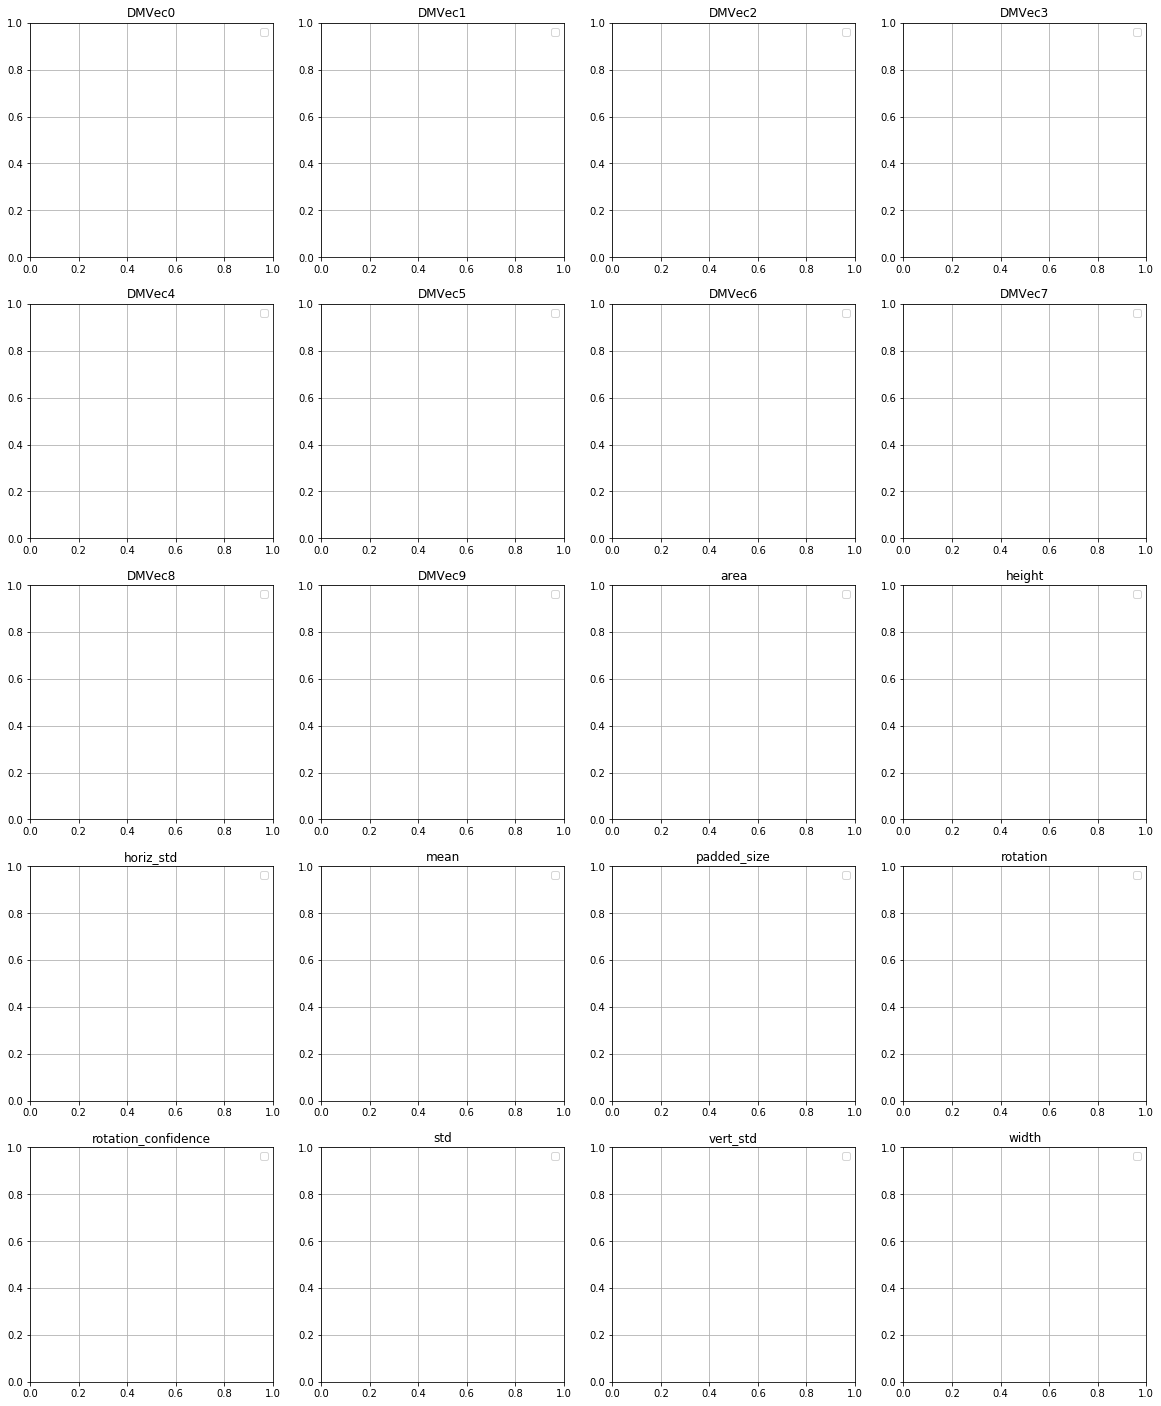

In [159]:
thresholds = []
features = []
labels = []
for structure in all_structures:
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl')
    for state in range(2):
        cells = pickle.load(open(fp[state],'rb'))
        cells = cells.drop(['left','top'],1)
        cells = np.asarray(cells)
        for k in range(len(cells)):
            cells[k][0] = cells[k][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        features.extend(origin)
        labels.extend([state]*len(origin))
features = np.array(features)
labels = np.array(labels)
figure(figsize=[20,25])
for k in range(features.shape[1]):
    subplot(5,4,k+1)
    x, y = CDF(features[labels==0,k],'negative')
    x, y = CDF(features[labels==1,k],'positive')
    x, y = CDF(features[:,k],'all')
    title(columns[k])
    grid(True)
    legend()
    ten = [x[np.argmin(np.absolute(y-0.01*(j+1)))] for j in range(99)]
    thresholds.append(ten)

In [163]:
len(features),len(labels)

(6415536, 6415536)

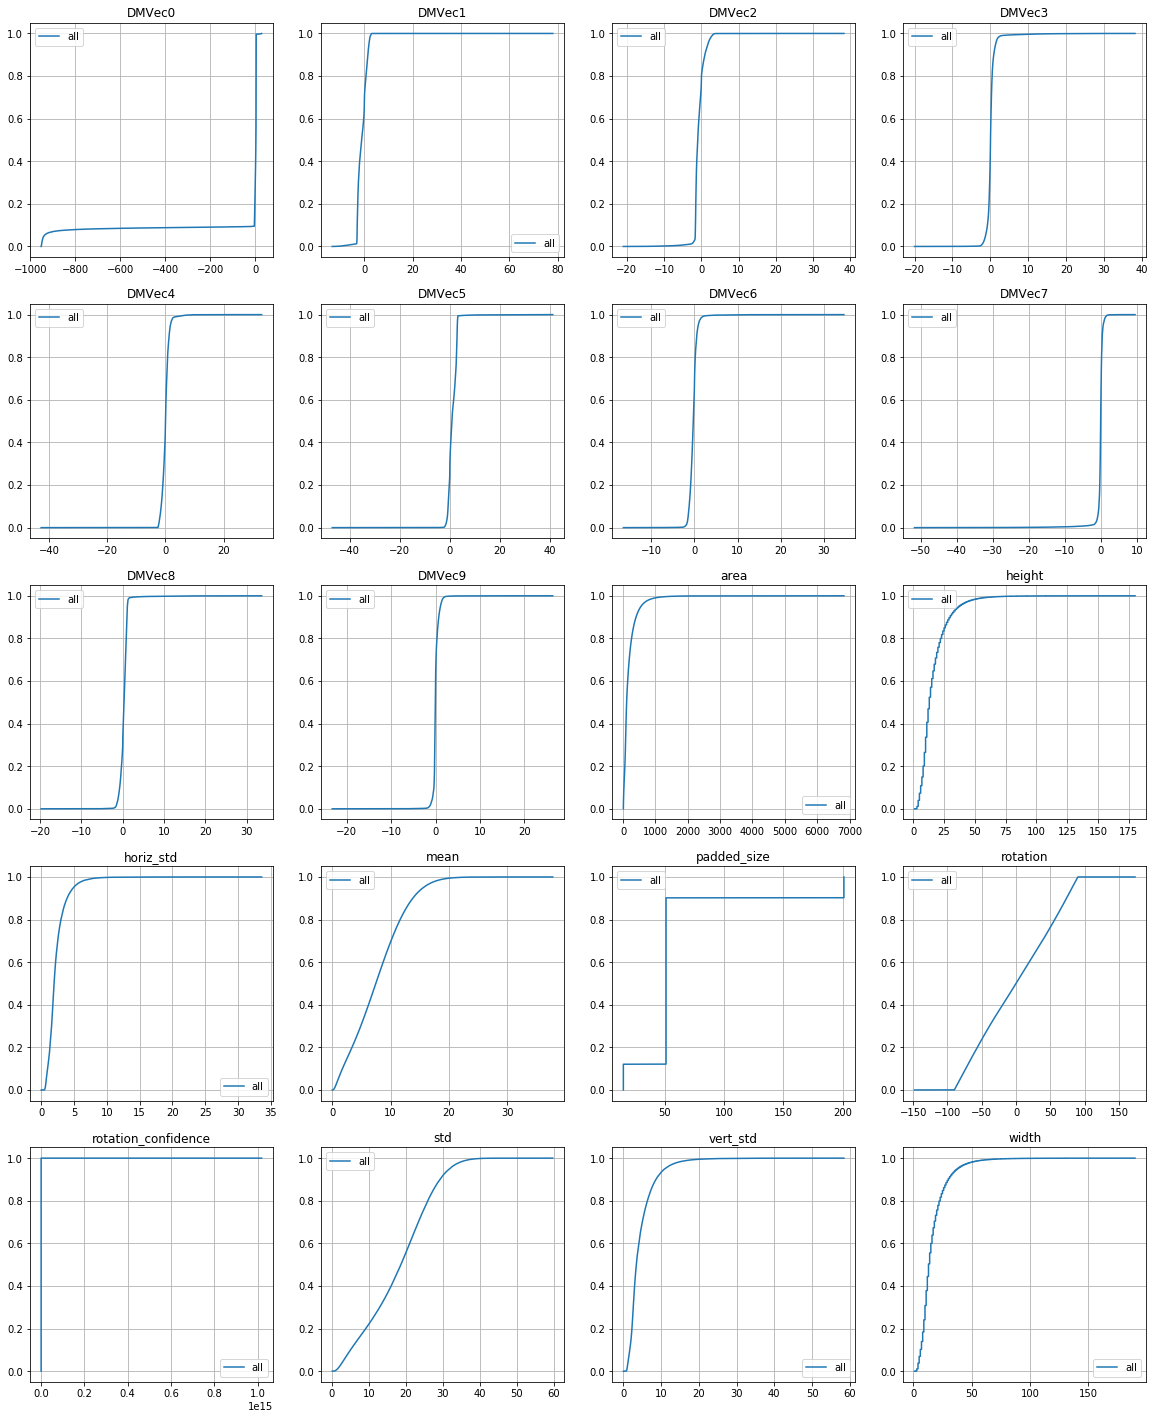

In [175]:
thresholds = []
figure(figsize=[20,25])
for k in range(features.shape[1]):
    subplot(5,4,k+1)
    x, y = CDF(features[:,k],'all')
    title(columns[k])
    grid(True)
    legend()
    ten = [x[np.argmin(np.absolute(y-0.005*(j+1)))] for j in range(20)]
    ten.extend([x[np.argmin(np.absolute(y-0.02*(j+1)))] for j in range(5,45)])
    ten.extend([x[np.argmin(np.absolute(y-0.005*(j+1)))] for j in range(180,199)])
    thresholds.append(ten)

In [180]:
len(thresholds[0])*20

1580

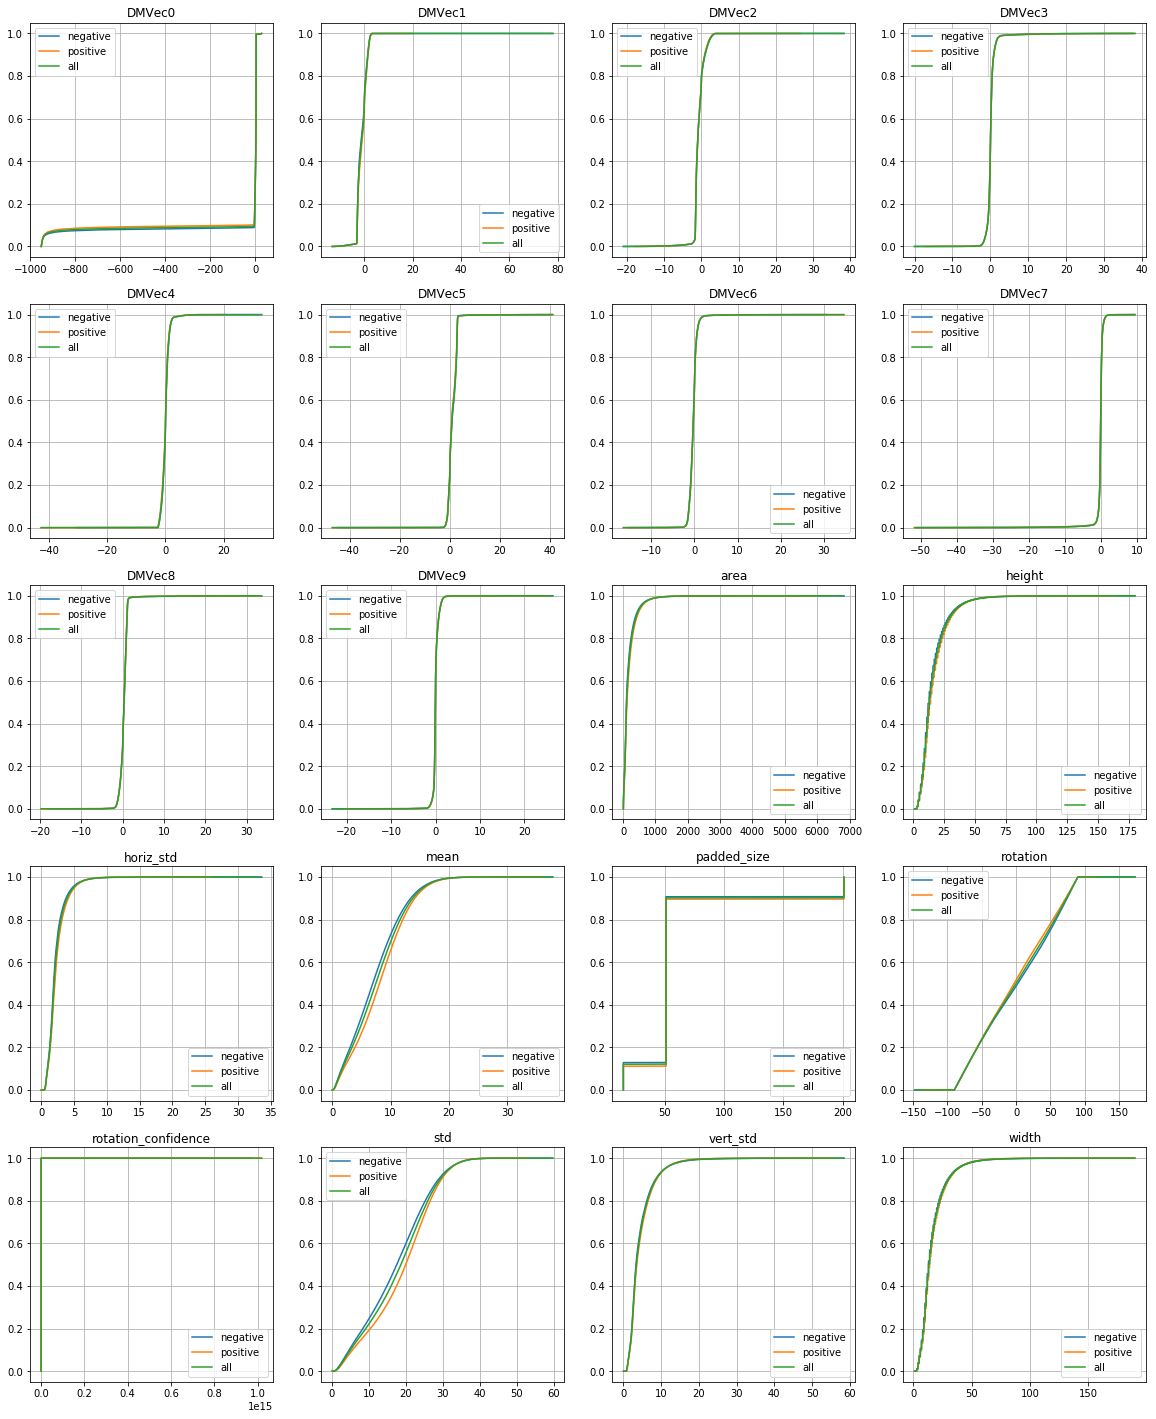

In [161]:
figure(figsize=[20,25])
for k in range(features.shape[1]):
    subplot(5,4,k+1)
    x, y = CDF(features[labels==0,k],'negative')
    x, y = CDF(features[labels==1,k],'positive')
    x, y = CDF(features[:,k],'all')
    title(columns[k])
    grid(True)
    legend()
#     ten = [x[np.argmin(np.absolute(y-0.01*(j+1)))] for j in range(99)]
#     thresholds.append(ten)
savefig('CellsByFeature.jpg')

In [53]:
import pickle

In [181]:
fp = os.environ['ROOT_DIR']+'/CSHL_data_processed/MD589/ThresholdsV5.pkl'
pickle.dump(thresholds,open(fp,'wb'))

In [36]:
def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        ! aws s3 cp --recursive $local_fp $s3_fp
    else:
        ! aws s3 cp $local_fp $s3_fp

In [182]:
setup_upload_from_s3('CSHL_data_processed/MD589/ThresholdsV5.pkl', recursive=False)

upload: ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/ThresholdsV5.pkl to s3://mousebrainatlas-data/CSHL_data_processed/MD589/ThresholdsV5.pkl


In [59]:
fp = os.environ['ROOT_DIR']+'CSHL_patch_samples_features/MD589/4N/MD589_4N_positive.pkl'
feature = pickle.load(open(fp,'rb'))

In [62]:
feature = np.array(feature)

In [31]:
def CDF_test(x, color):
    x=sort(x)
    size=x.shape[0]
    y=arange(0,size)/size
    threshold = (x.max()-x.min())/10
    ten_x = [x[np.argmin(np.absolute(x-x.min()-threshold*(j+1)))] for j in range(10)]
    ten_y = [y[np.argmin(np.absolute(x-x.min()-threshold*(j+1)))] for j in range(10)]
    if color:
        plot(x,y,color)
        plot(ten_x,ten_y,'ro')
    else:
        plot(x,y)
        plot(ten_x,ten_y,'o')
    return ten_x, ten_y

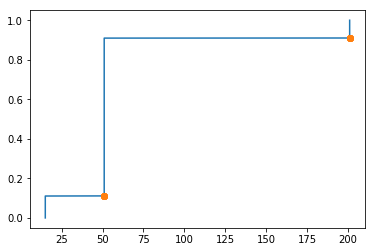

In [32]:
m,n = CDF_test(features[:,14], False)

In [14]:
for structure in all_structures:
    #structure = '12N'
    fp =[dir for dir in glob(cell_dir+structure+'/*')]
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        features.extend(np.array(clouds))
        labels.extend([state]*len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.30, random_state=6)
    y_pred_valid = get_scores(X_train, X_valid, y_train, param)
    pred = y_pred_valid>0
    #pred = get_predictions(y_pred_valid)
    acc = sum(pred ==y_valid)/len(y_valid)
    print(structure, features.shape[0], acc)

5N 88 1.0
6N 10 0.3333333333333333
7N 178 1.0
7n 252 0.9868421052631579
Amb 26 0.875
LC 48 0.9333333333333333
LRt 152 0.9782608695652174
Pn 202 0.9836065573770492
Tz 100 0.9666666666666667
VLL 138 1.0
RMC 114 0.8857142857142857
SNC 166 1.0
SNR 252 0.9736842105263158
3N 48 0.9333333333333333
4N 24 1.0
Sp5I 146 0.9545454545454546
Sp5O 136 0.975609756097561
Sp5C 282 1.0
PBG 52 0.8125
10N 92 0.9285714285714286
VCA 132 1.0
VCP 98 0.9666666666666667
DC 222 0.9402985074626866
AP 30 0.7777777777777778
12N 78 1.0
RtTg 30 0.7777777777777778
SC 364 1.0
IC 382 0.991304347826087
